In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd
import random
import math

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,8)

# Estadísticos
# ------------------------------------------------------------------------------
from scipy import stats
import researchpy as rp
from scipy.stats import levene
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm


# Para la gestión de los warning
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')




### ASUNCIONES

In [2]:
df= pd.read_pickle("../data/outliers_gestion.pkl")
df.head(2)

,fecha,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo,sensacion_termica,humedad,velocidad_viento,alquiler_casual,alquiler_registrado,total_alquileres
0,2018-01-01,Invierno,2018,enero,no_festivo,lunes,0,2,18.18125,80.5833,10.749882,331,654,985
1,2018-01-02,Invierno,2018,enero,no_festivo,martes,0,2,17.68695,69.6087,16.652113,131,670,801


Vamos comprobar la normalidad de nuestras variables respuestas para los dos modelos.

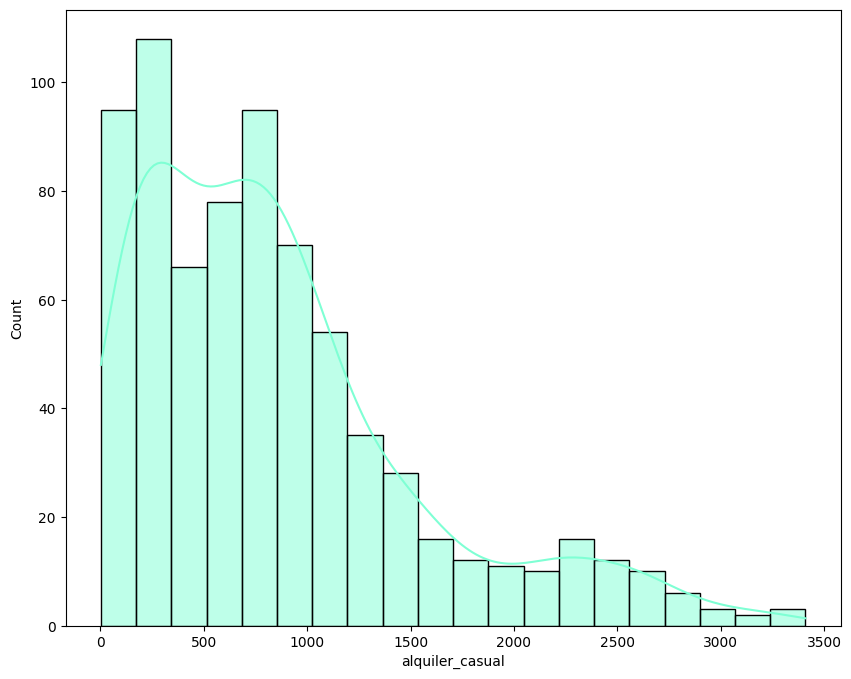

In [3]:
#Variable respuesta modelo I: 'alquiler_casual'

sns.histplot(df["alquiler_casual"], kde = True, color = "aquamarine");

In [4]:
stats.shapiro(df["alquiler_casual"])

ShapiroResult(statistic=0.885096549987793, pvalue=7.659812252880885e-23)

Raíz-cuadrada porque tenemos sesgo a la derecha

In [5]:
#Probamos de normalizar 'alquiler_casual' con la raiz cuadrada, ya que está muy sesgada a la izquierda

df["alquiler_casual_raiz"] = df["alquiler_casual"].apply(lambda x: math.sqrt(x))
df.head(2)

,fecha,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo,sensacion_termica,humedad,velocidad_viento,alquiler_casual,alquiler_registrado,total_alquileres,alquiler_casual_raiz
0,2018-01-01,Invierno,2018,enero,no_festivo,lunes,0,2,18.18125,80.5833,10.749882,331,654,985,18.193405
1,2018-01-02,Invierno,2018,enero,no_festivo,martes,0,2,17.68695,69.6087,16.652113,131,670,801,11.445523


In [6]:
#comprobamos con el shapiro si se han normalizado los datos 

stats.shapiro(df["alquiler_casual_raiz"])

ShapiroResult(statistic=0.9811133146286011, pvalue=4.260649788534465e-08)

In [7]:
#probamos a normalizar la variable con box-cox

df['alquiler_casual_boxcox'], lambda_ajustada = stats.boxcox(df['alquiler_casual'])
df.head(2)

,fecha,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo,sensacion_termica,humedad,velocidad_viento,alquiler_casual,alquiler_registrado,total_alquileres,alquiler_casual_raiz,alquiler_casual_boxcox
0,2018-01-01,Invierno,2018,enero,no_festivo,lunes,0,2,18.18125,80.5833,10.749882,331,654,985,18.193405,16.397820
1,2018-01-02,Invierno,2018,enero,no_festivo,martes,0,2,17.68695,69.6087,16.652113,131,670,801,11.445523,11.472437


In [8]:
stats.shapiro(df["alquiler_casual_boxcox"])

ShapiroResult(statistic=0.9915904402732849, pvalue=0.00036475612432695925)

Podemos visualizar la diferencia entre los datos normalizados y sin normalizar con un distplot

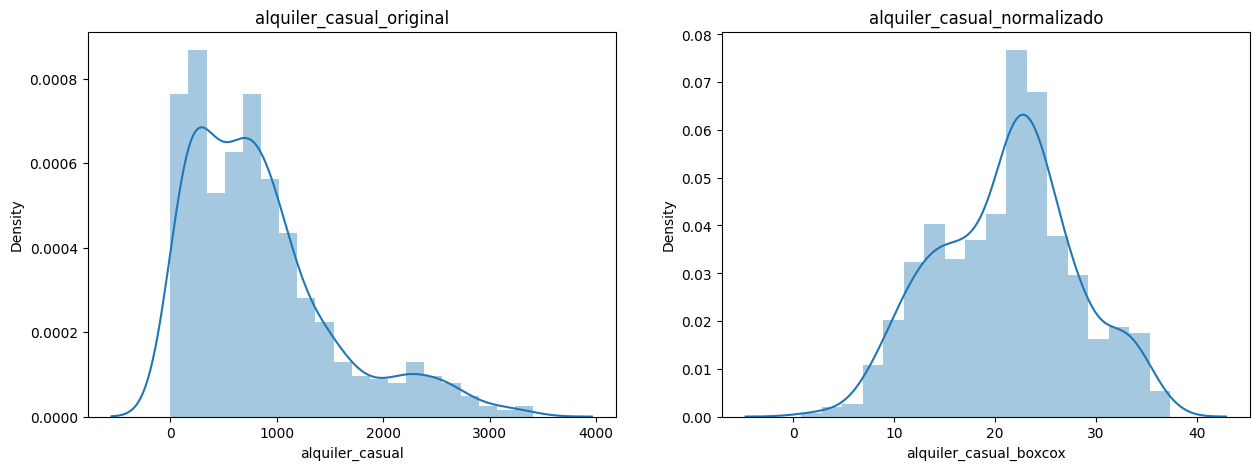

In [9]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))
axes[0].set_title('alquiler_casual_original')
axes[1].set_title('alquiler_casual_normalizado')
sns.distplot(df["alquiler_casual"] ,ax = axes[0])
sns.distplot(df["alquiler_casual_boxcox"], ax = axes[1]);

In [10]:
#Nos quedamos con la columna 'alquiler_casual_boxcox'

df.drop(['alquiler_casual', 'alquiler_casual_raiz'], axis = 1, inplace = True)
df.head()

,fecha,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo,sensacion_termica,humedad,velocidad_viento,alquiler_registrado,total_alquileres,alquiler_casual_boxcox
0,2018-01-01,Invierno,2018,enero,no_festivo,lunes,0,2,18.18125,80.5833,10.749882,654,985,16.397820
1,2018-01-02,Invierno,2018,enero,no_festivo,martes,0,2,17.68695,69.6087,16.652113,670,801,11.472437
2,2018-01-03,Invierno,2018,enero,no_festivo,miercoles,1,1,9.47025,43.7273,16.636703,1229,1349,11.076035
3,2018-01-04,Invierno,2018,enero,no_festivo,jueves,1,1,10.60610,59.0435,10.739832,1454,1562,10.613970
4,2018-01-05,Invierno,2018,enero,no_festivo,viernes,1,1,11.46350,43.6957,12.522300,1518,1600,9.475537


Con el box-cox los datos se han corregido bastante, pero siguen sin estar normalizados.

Con esta variable decidimos pasar directamente a un Decision Tree

In [11]:
#Lo primero que hacemos es estandarizar las variables numéricas

df_num = df.select_dtypes(include = np.number)


In [12]:
df_num.head(2)

,sensacion_termica,humedad,velocidad_viento,alquiler_registrado,total_alquileres,alquiler_casual_boxcox
0,18.18125,80.5833,10.749882,654,985,16.397820
1,17.68695,69.6087,16.652113,670,801,11.472437


In [13]:
#Iniciamos el método RobustScaler y lo aplicamos
robust = RobustScaler()
robust.fit(df_num)
X_robust = robust.transform(df_num)

In [14]:
numericas_robust = pd.DataFrame(X_robust, columns = df_num.columns)
numericas_robust.head(2)

,sensacion_termica,humedad,velocidad_viento,alquiler_registrado,total_alquileres,alquiler_casual_boxcox
0,-0.456399,0.856714,-0.208909,-1.319816,-1.274385,-0.583683
1,-0.492863,0.332554,0.687550,-1.312801,-1.340188,-1.121070


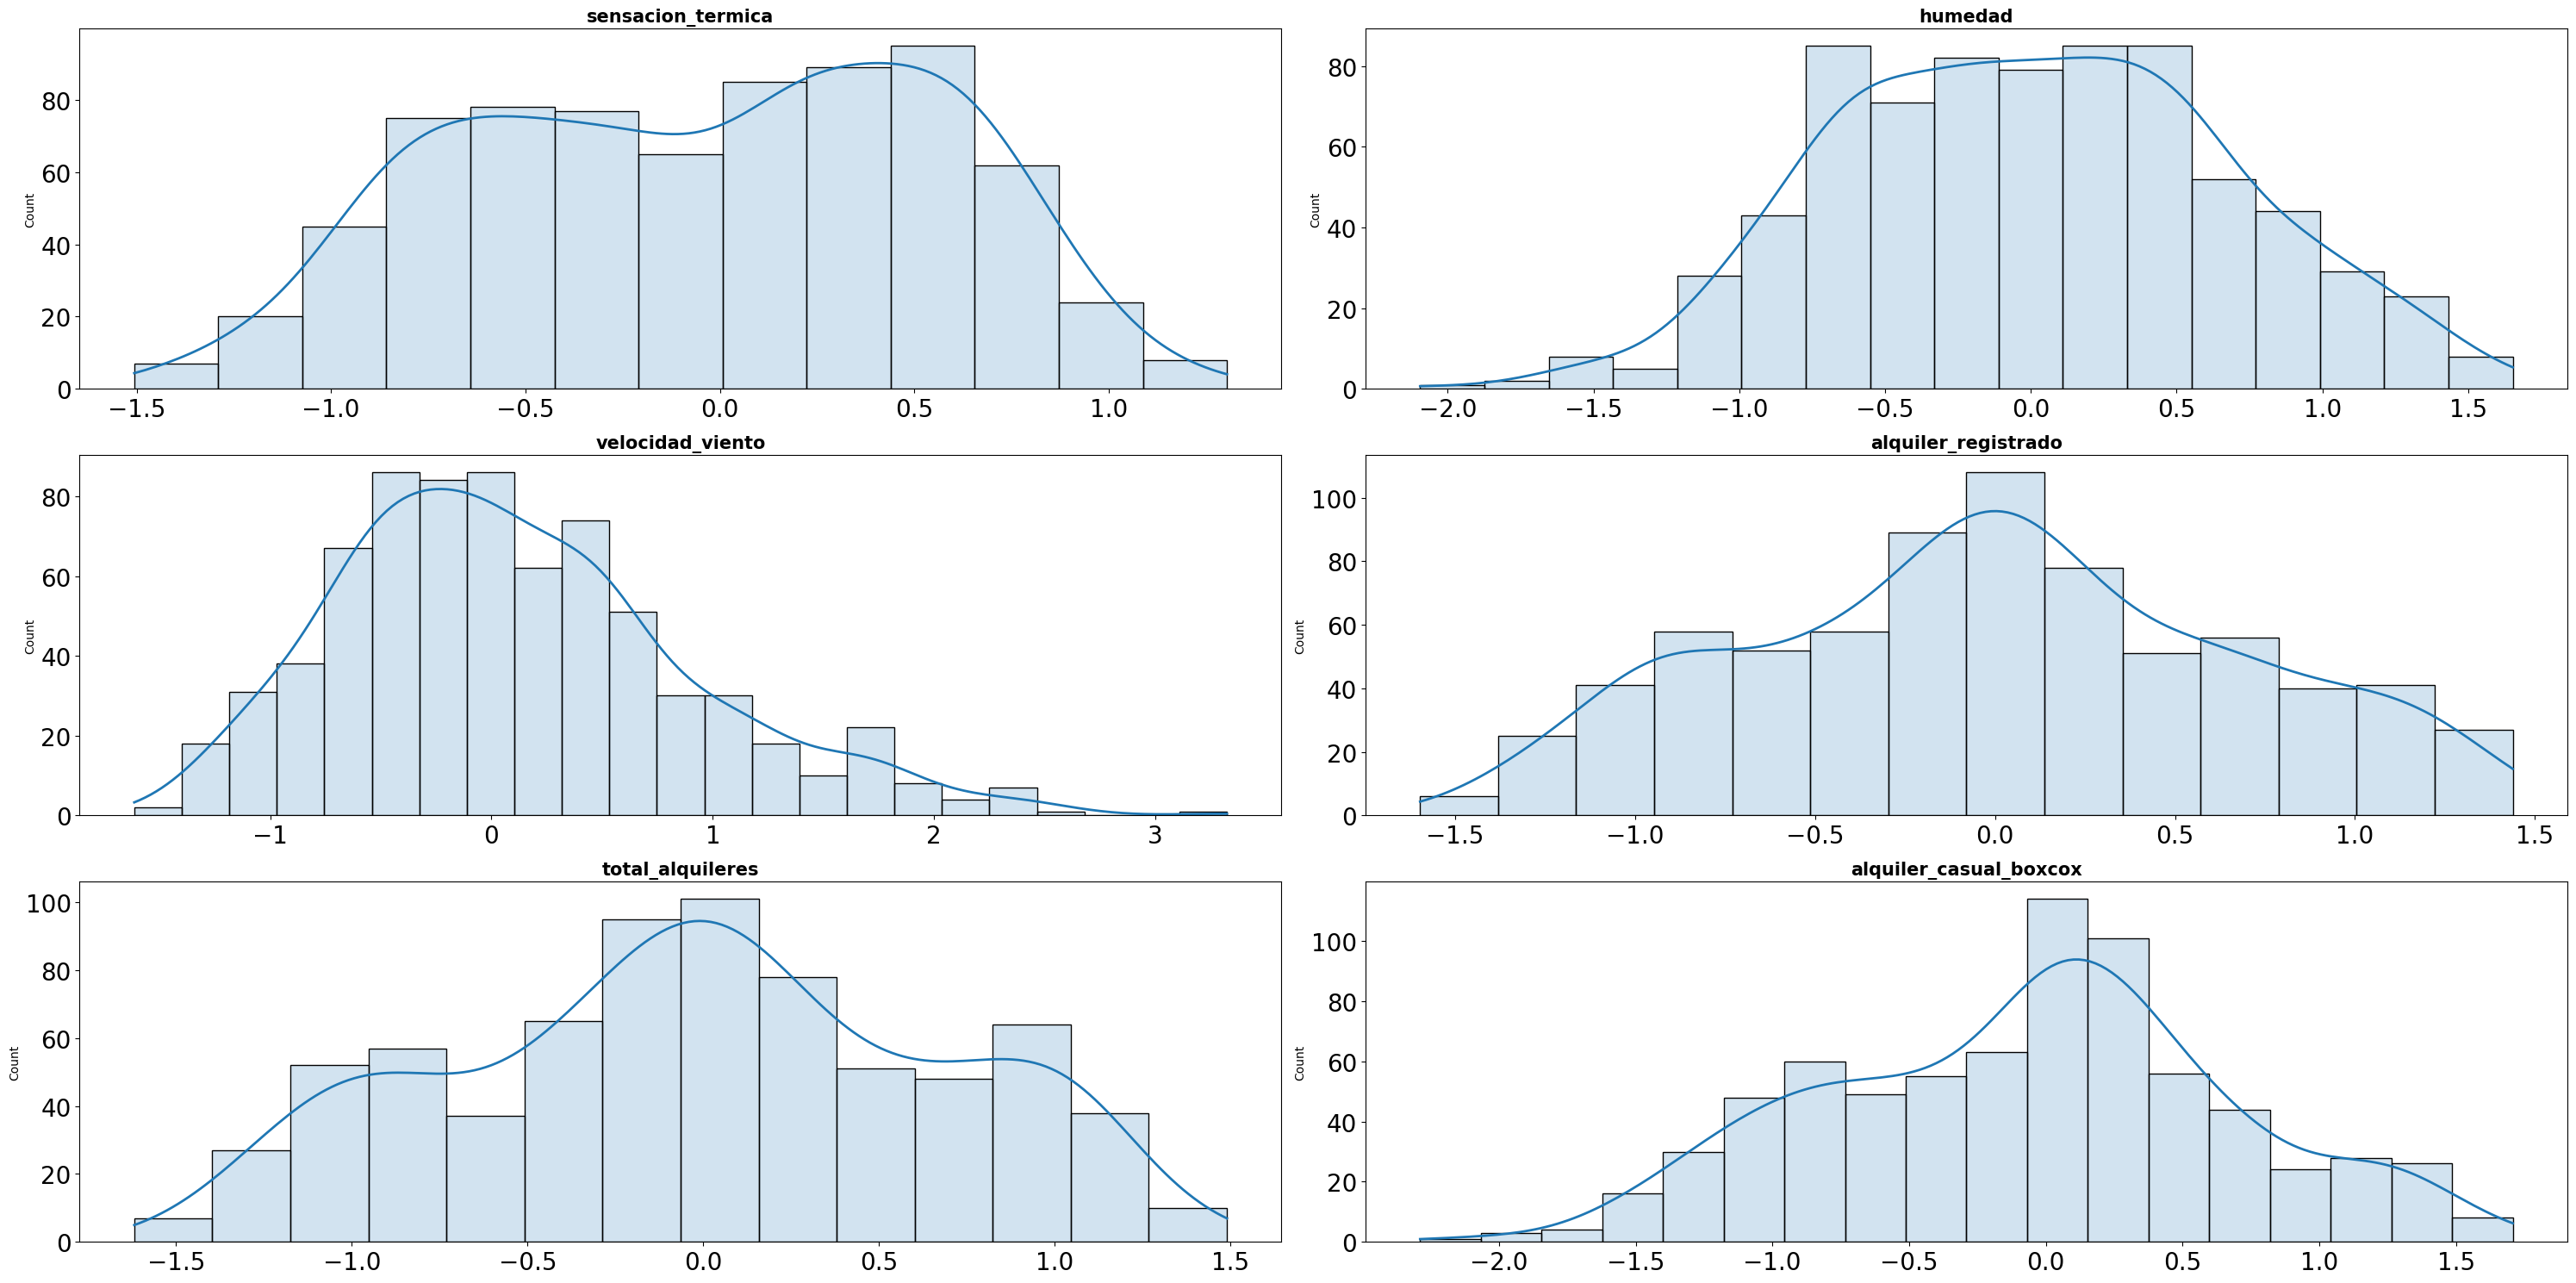

In [15]:
#Visualizamos la distribución de las variables numéricas una vez estandarizadas

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (30, 15))
columnas_robust = numericas_robust.columns
axes = axes.flat

for i, colum in enumerate(columnas_robust):
    sns.histplot(
        data = numericas_robust,
        x = colum,
        kde = True,
        line_kws = {"linewidth": 2},
        alpha = 0.2,
        ax = axes[i])
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    
fig.tight_layout();

In [16]:
#Adjuntamos las variables estandarizadas a nuestro dataframe

df_est = df_num[df_num.columns] = numericas_robust
df_est.head(2)


,sensacion_termica,humedad,velocidad_viento,alquiler_registrado,total_alquileres,alquiler_casual_boxcox
0,-0.456399,0.856714,-0.208909,-1.319816,-1.274385,-0.583683
1,-0.492863,0.332554,0.687550,-1.312801,-1.340188,-1.121070


Codificamos las variables categóricas

In [17]:
#Creamos un dataframe sólo con las variables categóricas

df_cat = df.select_dtypes(exclude=np.number).drop('fecha', axis = 1)
df_cat.head(2)

,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo
0,Invierno,2018,enero,no_festivo,lunes,0,2
1,Invierno,2018,enero,no_festivo,martes,0,2


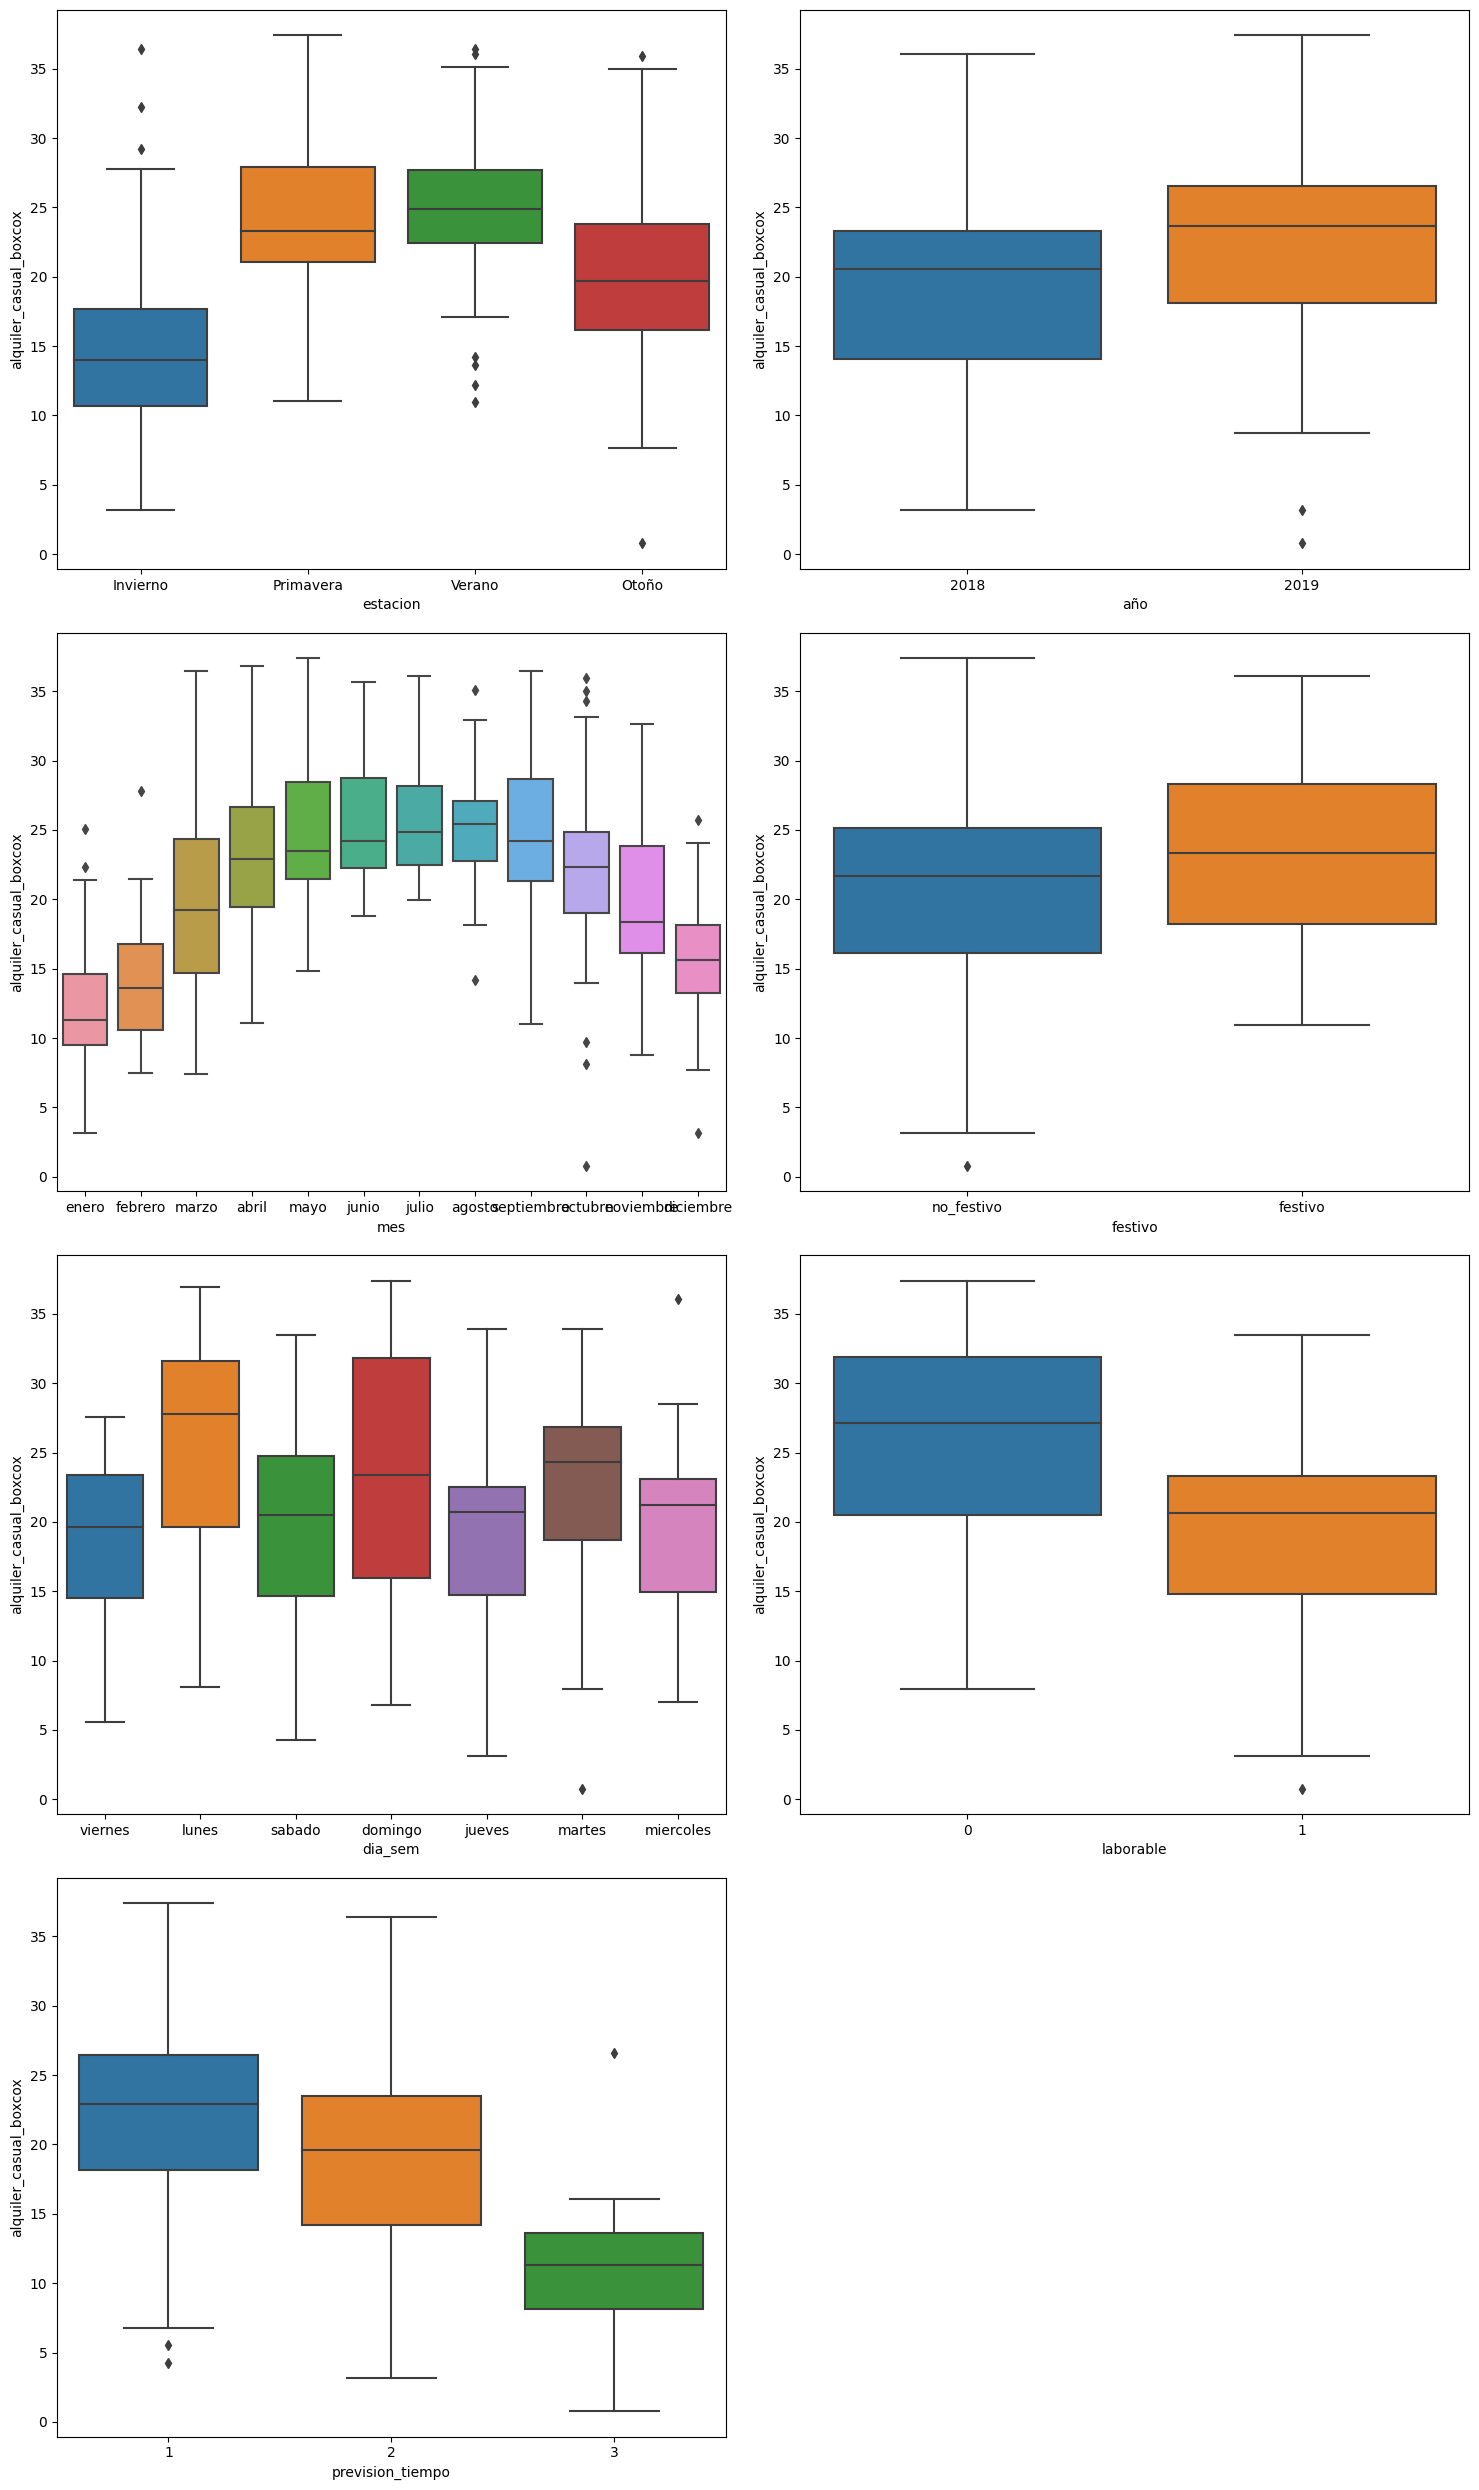

In [18]:
# sacamos boxplots para ver si las variables tienen orden:

fig, axes = plt.subplots(4, 2, figsize=(15, 25))
axes = axes.flat
lista_casual = df_cat.columns
for indice, elemento in enumerate(lista_casual):
    sns.boxplot(x = elemento, y = "alquiler_casual_boxcox", data = df, ax=axes[indice])
plt.tight_layout()
plt.delaxes(axes[-1])
plt.show();

Orden de las variables: (tomamos como referencia cada 3 puntos = 0.5 )
 
    - 'estaciones': {'invierno': 0, 'otoño' = 1, 'primavera': 1.4, 'verano': 1.5}

    - 'año': {'2018':0, '2019':0.5}

    - 'mes': {'enero':0, 'febrero':0.5, 'diciembre': 1,
    'noviembre': 1.5, 'marzo':1.5, 'octubr':2, 'abril': 2, 'mayo': 2, 'junio':2.5, 'julio':2.5, 'septiembre':2.5, 'agosto':2.7 }

    - 'festivo': consideramos que no tiene orden destacable

    - 'dia_sem': {'miercoles':0, 'jueves':0, 'viernes':0, 'sábado':0,
    'martes':0.5, 'lunes': 0.5, 'domingo':0.5}

    - 'laborable': {1:0, 0:1}

    - 'prevision_tiempo': {3:0, 2:1.5, 1:2}

In [19]:
#Lo primero que tenemos que hacer es resetear los índices de df, ya que hemos eliminado algunos registros

df = df.reset_index(drop= True)

In [20]:
#creamos los diccionarios con el orden que queremos establecer

lista_dict = [{'Invierno': 0, 'Otoño':1, 'Primavera': 1.4, 'Verano': 1.5}, {'2018':0, '2019':0.5}, {'enero':0, 'febrero':0.5, 'diciembre': 1,
                'noviembre': 1.5, 'marzo':1.5, 'octubre':2, 'abril': 2, 'mayo': 2, 'junio':2.5, 'julio':2.5, 'septiembre':2.5, 'agosto':2.7 },
                {'miercoles':0, 'jueves':0, 'viernes':0, 'sabado':0, 'martes':0.5, 'lunes': 0.5, 'domingo':0.5}, {1:0, 0:1}, {3:0, 2:1.5, 1:2}]

#creamos una lista con las columnas que tienen orden
lista_col = df_cat.columns.drop('festivo')


In [21]:
#Usamos map para codificar las columnas que tienen orden
#creamos un dataframe vacío para ir añadiendo las columnas codificadas
df_enco = pd.DataFrame()

for dic, col in zip(lista_dict, lista_col):   
    
    df_enco[f'{col}_map'] = df[col].map(dic)
    
df_enco.head(2)

,estacion_map,año_map,mes_map,dia_sem_map,laborable_map,prevision_tiempo_map
0,0.0,0.0,0.0,0.5,1,1.5
1,0.0,0.0,0.0,0.5,1,1.5


In [22]:
for col in df_enco.columns:
    print(df_enco[col].unique())
    print('-------------------------')

[0.  1.4 1.5 1. ]
-------------------------
[0.0, 0.5]
Categories (2, float64): [0.0, 0.5]
-------------------------
[0.  0.5 1.5 2.  2.5 2.7 1. ]
-------------------------
[0.5 0. ]
-------------------------
[1, 0]
Categories (2, int64): [1, 0]
-------------------------
[1.5, 2.0, 0.0]
Categories (3, float64): [2.0, 1.5, 0.0]
-------------------------


In [23]:
#unimos los dataframes de las variables numéricas estandarizadas con el dataframe de las variables categóricas codificadas

df_estenc = pd.concat([numericas_robust, df_enco], axis=1)
df_estenc.head()

,sensacion_termica,humedad,velocidad_viento,alquiler_registrado,total_alquileres,alquiler_casual_boxcox,estacion_map,año_map,mes_map,dia_sem_map,laborable_map,prevision_tiempo_map
0,-0.456399,0.856714,-0.208909,-1.319816,-1.274385,-0.583683,0.0,0.0,0.0,0.5,1,1.5
1,-0.492863,0.332554,0.687550,-1.312801,-1.340188,-1.121070,0.0,0.0,0.0,0.5,1,1.5
2,-1.098990,-0.903573,0.685210,-1.067733,-1.144211,-1.164319,0.0,0.0,0.0,0.0,0,2.0
3,-1.015201,-0.172053,-0.210435,-0.969093,-1.068038,-1.214733,0.0,0.0,0.0,0.0,0,2.0
4,-0.951952,-0.905082,0.060294,-0.941035,-1.054448,-1.338943,0.0,0.0,0.0,0.0,0,2.0


In [24]:
#guardamos el dataframe

df_estenc.to_csv('../data/df_estand_encod.csv')

Decision Tree:

In [25]:
# dividimos en dos dataframes: x(predictoras) e y (variable respuesta)
# creamos los 4 grupos (train-test)
 
x= df_estenc.drop("alquiler_casual_boxcox", axis= 1)
y = df_estenc["alquiler_casual_boxcox"]

x_train_cas, x_test_cas, y_train_cas, y_test_cas = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [26]:
# instanciamos el método y lo ajustamos:

arbol_casual = DecisionTreeRegressor(random_state =0)
arbol_casual.fit(x_train_cas, y_train_cas)

DecisionTreeRegressor(random_state=0)

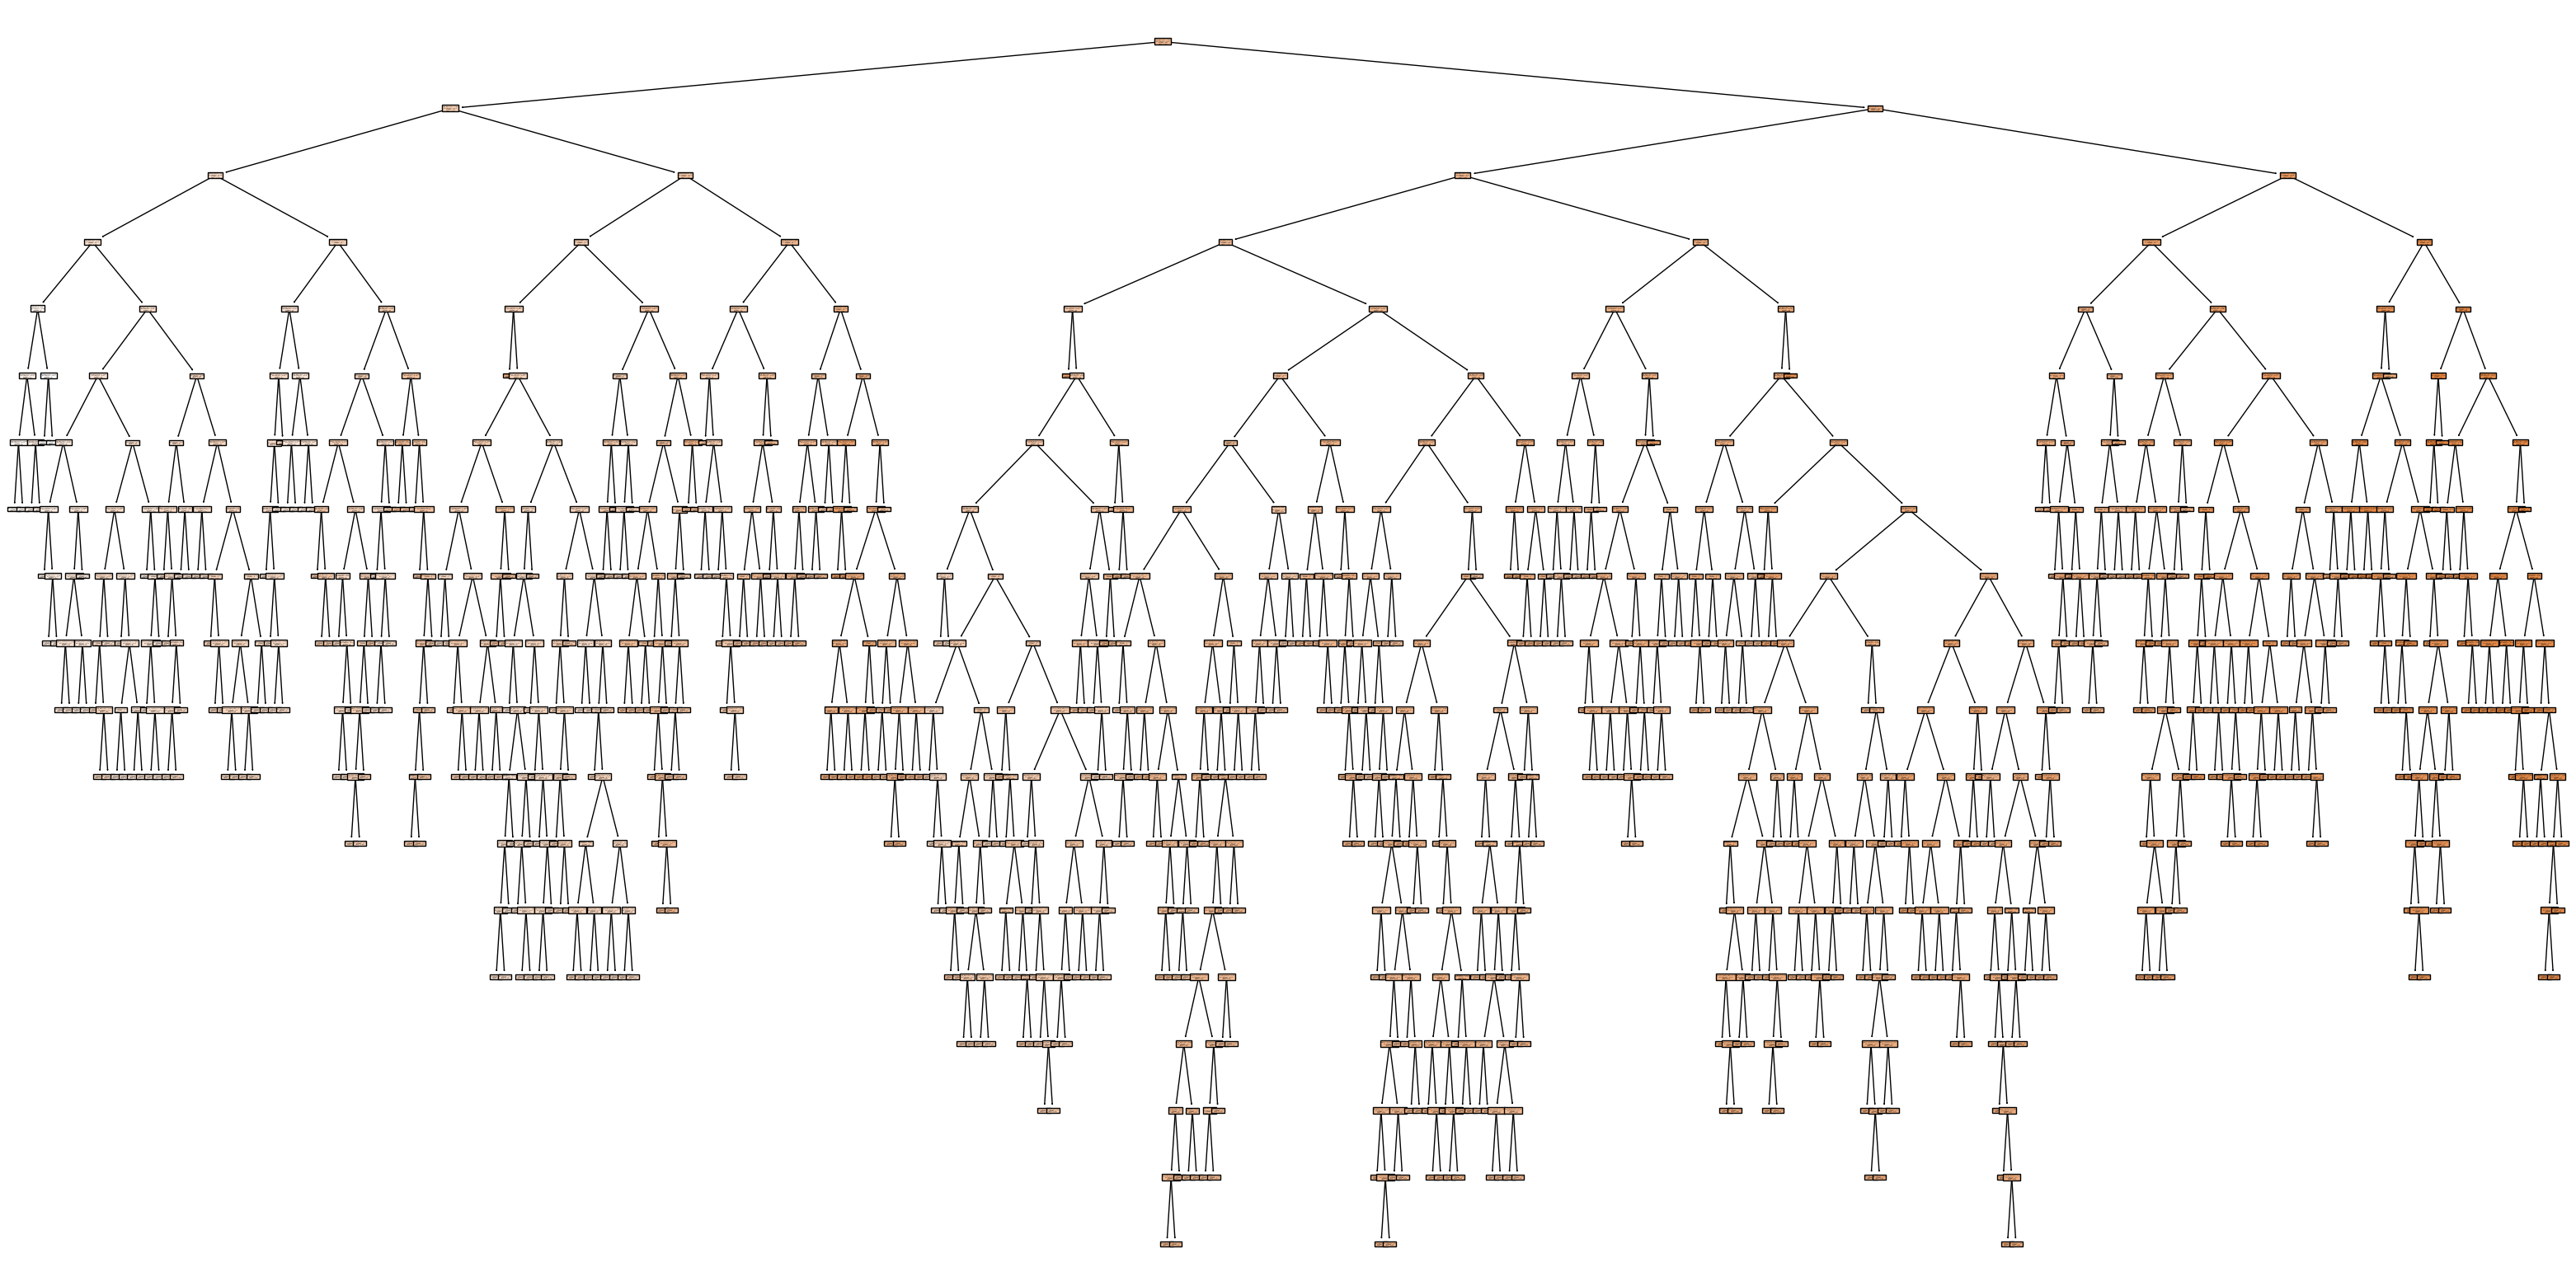

In [27]:
# imprimimos:

fig = plt.figure(figsize = (40, 20))
tree.plot_tree(arbol_casual, feature_names = list(x_train_cas.columns), filled = True);

In [28]:
# calculamos la profundidad y la raíz cuadrada de las variables:

print(arbol_casual.tree_.max_depth)
print("___________")
max_features = np.sqrt(len(x_train_cas.columns))
max_features

18
___________


3.3166247903554

In [29]:
y_pred_test_casual = arbol_casual.predict(x_test_cas)
y_pred_train_casual = arbol_casual.predict(x_train_cas)

In [30]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    """con esta función calculamos las métricas del árbol

    Args:
        y_test: datos test
        y_train: datos para entrenar
        y_test_pred: datos predichos predictoras (test)
        y_train_pred: datos predichos predictoras (entrenamiento)
        tipo_modelo: nombre que le queremos dar a nuestro modelo

    Returns:
        df: dataframe con las métricas
    """
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [31]:
arbol_casual_resultado = metricas(y_test_cas, y_train_cas, y_pred_test_casual, y_pred_train_casual, "DT Casual I")
arbol_casual_resultado

,MAE,MSE,RMSE,R2,set,modelo
0,0.191011,0.072931,0.270057,0.87259,test,DT Casual I
1,0.000000,0.000000,0.000000,1.00000,train,DT Casual I


In [32]:
param_casual = {"max_depth": [6,8,10], # tenemos overfitting reducimos la profundidad del modelo, la nuestra anterior era de 18. 
        "max_features": [1,2,3,4],# ponemos como límite el 4 ya que el resultado de la raiz cuadrada es 3.3
        "min_samples_split": [10, 50, 100],
        "min_samples_leaf": [10,50, 100]}

In [33]:
gs_casual = GridSearchCV(
            estimator=DecisionTreeRegressor(), # tipo de modelo que queremos hacer
            param_grid= param_casual, # hiperparámetros nuevos
            cv=10, # crossvalidation 
            verbose= 0,
            return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error") # la métrica que queremos que nos devuelva

gs_casual.fit(x_train_cas, y_train_cas)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [6, 8, 10], 'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [34]:
mejor_modelo_casual = gs_casual.best_estimator_
mejor_modelo_casual

DecisionTreeRegressor(max_depth=8, max_features=3, min_samples_leaf=10,
                      min_samples_split=10)

In [35]:
y_pred_test_casual_2 = mejor_modelo_casual.predict(x_test_cas)
y_pred_train_casual_2 = mejor_modelo_casual.predict(x_train_cas)

In [36]:
arbol_casual_resultado_2 = metricas(y_test_cas, y_train_cas, y_pred_test_casual_2, y_pred_train_casual_2, "DT Casual II")
arbol_casual_resultado_2

,MAE,MSE,RMSE,R2,set,modelo
0,0.252052,0.109077,0.330267,0.809443,test,DT Casual II
1,0.204170,0.083198,0.288441,0.851062,train,DT Casual II


In [37]:
param_casual = {"max_depth": [12,14,16], # tenemos overfitting reducimos la profundidad del modelo, la nuestra anterior era de 18. 
        "max_features": [2,3,4],# ponemos como límite el 4 ya que el resultado de la raiz cuadrada es 3.3
        "min_samples_split": [10,20],
        "min_samples_leaf": [10,20]}

In [38]:
gs_casual = GridSearchCV(
            estimator=DecisionTreeRegressor(), # tipo de modelo que queremos hacer
            param_grid= param_casual, # hiperparámetros nuevos
            cv=10, # crossvalidation 
            verbose= 0,
            return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error") # la métrica que queremos que nos devuelva

gs_casual.fit(x_train_cas, y_train_cas)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [12, 14, 16], 'max_features': [2, 3, 4],
                         'min_samples_leaf': [10, 20],
                         'min_samples_split': [10, 20]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [39]:
y_pred_test_casual_3 = mejor_modelo_casual.predict(x_test_cas)
y_pred_train_casual_3 = mejor_modelo_casual.predict(x_train_cas)

In [40]:
arbol_casual_resultado_3 = metricas(y_test_cas, y_train_cas, y_pred_test_casual_3, y_pred_train_casual_3, "DT Casual III")
arbol_casual_resultado_3

,MAE,MSE,RMSE,R2,set,modelo
0,0.252052,0.109077,0.330267,0.809443,test,DT Casual III
1,0.204170,0.083198,0.288441,0.851062,train,DT Casual III


In [41]:
dt_resultados_casual = pd.concat([arbol_casual_resultado, arbol_casual_resultado_2, arbol_casual_resultado_3], axis = 0)
dt_resultados_casual

,MAE,MSE,RMSE,R2,set,modelo
0,0.191011,0.072931,0.270057,0.872590,test,DT Casual I
1,0.000000,0.000000,0.000000,1.000000,train,DT Casual I
0,0.252052,0.109077,0.330267,0.809443,test,DT Casual II
1,0.204170,0.083198,0.288441,0.851062,train,DT Casual II
0,0.252052,0.109077,0.330267,0.809443,test,DT Casual III
1,0.204170,0.083198,0.288441,0.851062,train,DT Casual III


Creamos un Random Forest:

Como ya tenemos creadas las variables, vamos directamente a crear el bosque

In [42]:
param_rf_casual = {"max_depth": [11, 12],
        "max_features": [7, 8],
        "min_samples_split": [11, 12],
        "min_samples_leaf": [56, 57],
        "n_estimators": [100]}

gs_rf_casual = GridSearchCV(
            estimator=RandomForestRegressor(n_estimators=100), 
            param_grid= param_rf_casual,
            cv=10,
            verbose=0, 
            return_train_score = True,
            scoring="neg_mean_squared_error") 

gs_rf_casual.fit(x_train_cas, y_train_cas)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [11, 12], 'max_features': [7, 8],
                         'min_samples_leaf': [56, 57],
                         'min_samples_split': [11, 12], 'n_estimators': [100]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [43]:
bosque_casual = gs_rf_casual.best_estimator_
bosque_casual

RandomForestRegressor(max_depth=11, max_features=8, min_samples_leaf=56,
                      min_samples_split=12)

  0%|          | 0/100 [00:00<?, ?it/s]


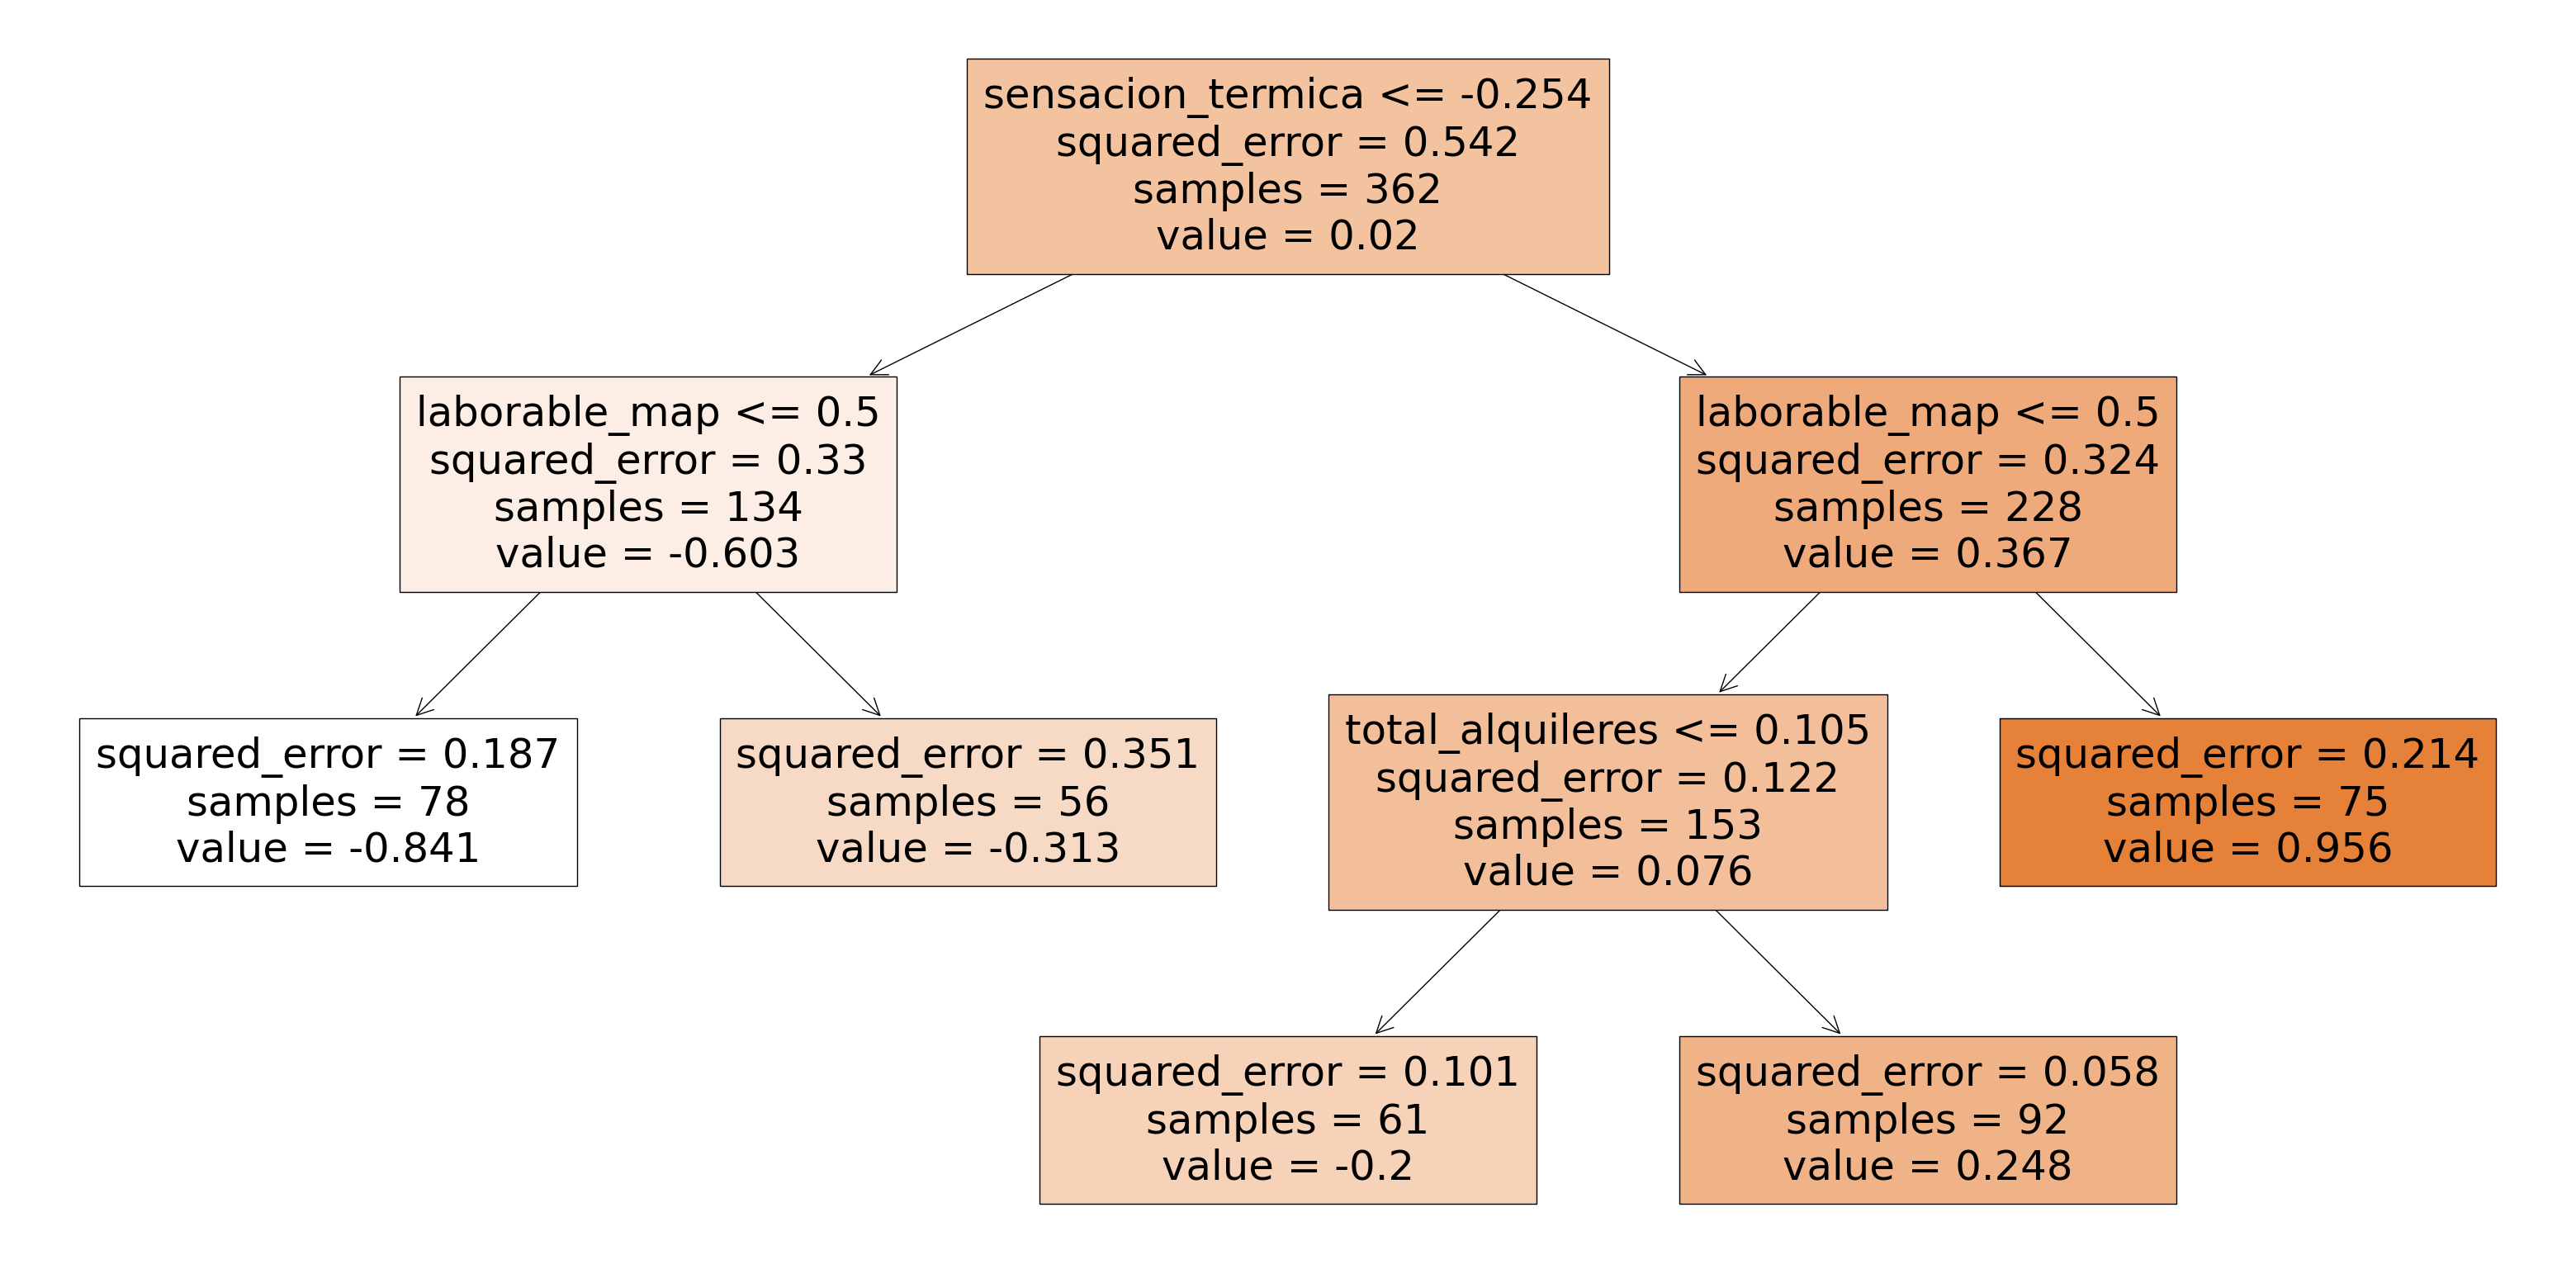

In [44]:
for arbol in tqdm(bosque_casual):
    fig = plt.figure(figsize=(40, 20))
    tree.plot_tree(arbol, feature_names= list(x_train_cas.columns), filled = True)
    plt.savefig("../graficas/random_forest_casual.png");
    break

In [45]:
y_pred_test_rf = bosque_casual.predict(x_test_cas)
y_pred_train_rf = bosque_casual.predict(x_train_cas)

results_forest_casual = metricas(y_test_cas, y_train_cas, y_pred_test_rf, y_pred_train_rf, "RF Casual I")
results_forest_casual

,MAE,MSE,RMSE,R2,set,modelo
0,0.288123,0.128706,0.358756,0.775152,test,RF Casual I
1,0.257759,0.116322,0.341059,0.791766,train,RF Casual I


In [46]:
param_rf_casual = {"max_depth": [20],
        "max_features": [8,9],
        "min_samples_split": [11, 12],
        "min_samples_leaf": [56, 57],
        "n_estimators": [100]}

gs_rf_casual = GridSearchCV(
            estimator=RandomForestRegressor(n_estimators=100), 
            param_grid= param_rf_casual,
            cv=10,
            verbose=0, 
            return_train_score = True,
            scoring="neg_mean_squared_error") 

gs_rf_casual.fit(x_train_cas, y_train_cas)
bosque_casual = gs_rf_casual.best_estimator_
bosque_casual

RandomForestRegressor(max_depth=20, max_features=8, min_samples_leaf=56,
                      min_samples_split=12)

In [47]:
y_pred_test_rf_2 = bosque_casual.predict(x_test_cas)
y_pred_train_rf_2 = bosque_casual.predict(x_train_cas)

results_forest_casual_2 = metricas(y_test_cas, y_train_cas, y_pred_test_rf_2, y_pred_train_rf_2, "RF Casual II")
results_forest_casual_2

,MAE,MSE,RMSE,R2,set,modelo
0,0.287501,0.126284,0.355364,0.779383,test,RF Casual II
1,0.259232,0.119317,0.345423,0.786404,train,RF Casual II


In [48]:
param_rf_casual = {"max_depth": [4,6],
        "max_features": [4],
        "min_samples_split": [11, 12],
        "min_samples_leaf": [56, 57],
        "n_estimators": [100]}

gs_rf_casual = GridSearchCV(
            estimator=RandomForestRegressor(n_estimators=100), 
            param_grid= param_rf_casual,
            cv=10,
            verbose=0, 
            return_train_score = True,
            scoring="neg_mean_squared_error") 

gs_rf_casual.fit(x_train_cas, y_train_cas)
bosque_casual = gs_rf_casual.best_estimator_
bosque_casual

RandomForestRegressor(max_depth=4, max_features=4, min_samples_leaf=56,
                      min_samples_split=11)

In [49]:
y_pred_test_rf_3 = bosque_casual.predict(x_test_cas)
y_pred_train_rf_3 = bosque_casual.predict(x_train_cas)

results_forest_casual_3 = metricas(y_test_cas, y_train_cas, y_pred_test_rf_3, y_pred_train_rf_3, "RF Casual III")
results_forest_casual_3

,MAE,MSE,RMSE,R2,set,modelo
0,0.295143,0.143211,0.378432,0.749811,test,RF Casual III
1,0.285317,0.143200,0.378418,0.743649,train,RF Casual III


In [50]:
rf_resultados_casual = pd.concat([results_forest_casual, results_forest_casual_2, results_forest_casual_3], axis = 0)
rf_resultados_casual

,MAE,MSE,RMSE,R2,set,modelo
0,0.288123,0.128706,0.358756,0.775152,test,RF Casual I
1,0.257759,0.116322,0.341059,0.791766,train,RF Casual I
0,0.287501,0.126284,0.355364,0.779383,test,RF Casual II
1,0.259232,0.119317,0.345423,0.786404,train,RF Casual II
0,0.295143,0.143211,0.378432,0.749811,test,RF Casual III
1,0.285317,0.143200,0.378418,0.743649,train,RF Casual III


In [51]:
resultados_alquiler_casual = pd.concat([dt_resultados_casual,rf_resultados_casual], axis= 0)
resultados_alquiler_casual.to_csv("../data/resultados_alquiler_casual.csv")

In [52]:
resultados_alquiler_casual

,MAE,MSE,RMSE,R2,set,modelo
0,0.191011,0.072931,0.270057,0.872590,test,DT Casual I
1,0.000000,0.000000,0.000000,1.000000,train,DT Casual I
0,0.252052,0.109077,0.330267,0.809443,test,DT Casual II
1,0.204170,0.083198,0.288441,0.851062,train,DT Casual II
0,0.252052,0.109077,0.330267,0.809443,test,DT Casual III
1,0.204170,0.083198,0.288441,0.851062,train,DT Casual III
0,0.288123,0.128706,0.358756,0.775152,test,RF Casual I
1,0.257759,0.116322,0.341059,0.791766,train,RF Casual I
0,0.287501,0.126284,0.355364,0.779383,test,RF Casual II
1,0.259232,0.119317,0.345423,0.786404,train,RF Casual II


# CONCLUSIONES:

- El primero Decission Tree queda descartado por overfitting.

- El resto de modelos tienen éxito ya que el R2 son superiores a 0.7 y el resto de parámetros son valores bajos.